In [3]:
import numpy as np
import mysql.connector as connection
import pandas as pd
from scipy.stats import zscore
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, cross_val_predict,ShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from joblib import dump, load
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as msa

import category_encoders as ce
import catboost as cb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [8]:
mydb = connection.connect(host="192.168.0.22", database = 'multilab',user="mlab1", passwd="adminmlab2",use_pure=True)

ProgrammingError: 1045 (28000): Access denied for user 'mlab1'@'DESKTOP-I2RB40E' (using password: YES)

In [5]:
años = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021]
lista_db = []
try:
    mydb = connection.connect(host="localhost", database = 'multilab',user="root", passwd="",use_pure=True)
    for año in años:
        query = f"Select * from muestra_{año};"
        lista_db.append(pd.read_sql(query,mydb))
    mydb.close() #close the connection
except Exception as e:
    mydb.close()
    print(str(e))

NameError: name 'mydb' is not defined

In [62]:
db_filtrada = []
for db in lista_db:
    db_filtrada.append(db[[ 'ph', 'n', 'mo', 'k', 'ca', 'mg','al',"cic"]])

In [63]:
df = pd.concat(db_filtrada)


# Aluminio

In [64]:
df_al = df[[ 'ph', 'n', 'mo', 'k', 'ca', 'mg','al']]

In [65]:
df_al = df_al.dropna()

In [66]:
cols = df_al.columns.values
df_al = df_al.replace(",",".",regex=True)




In [69]:
df_al[cols] = df_al[cols].apply(pd.to_numeric, errors='coerce', axis=1)
df_al = df_al.dropna()

In [70]:
import smogn

In [71]:
prueba = smogn.smoter(

    data = df_al, 
    y = "al",
    rel_thres = 0.80,         ## positive real number (0 < R < 1)
    rel_method = 'auto',      ## string ('auto' or 'manual')
     samp_method = 'extreme',  ## string ('balance' or 'extreme')
    rel_xtrm_type = 'high',   ## string ('low' or 'both' or 'high')
    rel_coef = 2.25      
)

r_index: 100%|##########| 3762/3762 [00:03<00:00, 1202.23it/s]


In [72]:
import resreg
from sklearn.preprocessing import RobustScaler

X = prueba[['ph',  'mo', 'k', 'ca', 'mg']]
y = prueba["al"]

sc = StandardScaler()
train_cbe = sc.fit_transform(X)
X_train, X_valid, y_train, y_valid = train_test_split(train_cbe, y, test_size=0.2, random_state=42)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [31]:
# check xgboost version
import xgboost as xg

In [78]:
model =   xg.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=4, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model.fit(X_train, y_train)

[01:01:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4603,
             enable_categorical=False, gamma=0.0468, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=4,
             min_child_weight=1.7817, missing=nan, monotone_constraints='()',
             n_estimators=2200, n_jobs=12, nthread=-1, num_parallel_tree=1,
             predictor='auto', random_state=7, reg_alpha=0.464,
             reg_lambda=0.8571, scale_pos_weight=1, silent=1, subsample=0.5213,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [74]:
import pickle
pickle.dump(sc, open('sc_al.pkl','wb'))

pickle.dump(model, open('model_al.pkl','wb'))

In [79]:
pred = model.predict(X_eval)
rmse = (np.sqrt(mean_squared_error(y_eval, pred)))
r2 = r2_score(y_eval, pred)
print("Testing performance")
print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 0.90
R2: 0.60


In [80]:
test_df = pd.read_excel("test.xlsx",sheet_name="Al")

In [81]:

test_df = test_df[[ 'pH',  'M.O.', 'K', 'Ca', 'Mg',"Al"]]
X = test_df[[ 'pH', 'M.O.', 'K', 'Ca', 'Mg',]]
y = test_df[["Al"]]
test = sc.transform(X)
pred = np.round(model.predict(test),2)
rmse = (np.sqrt(mean_squared_error(y, pred)))
r2 = r2_score(y, pred)
print("Testing performance")
print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 1.11
R2: 0.59


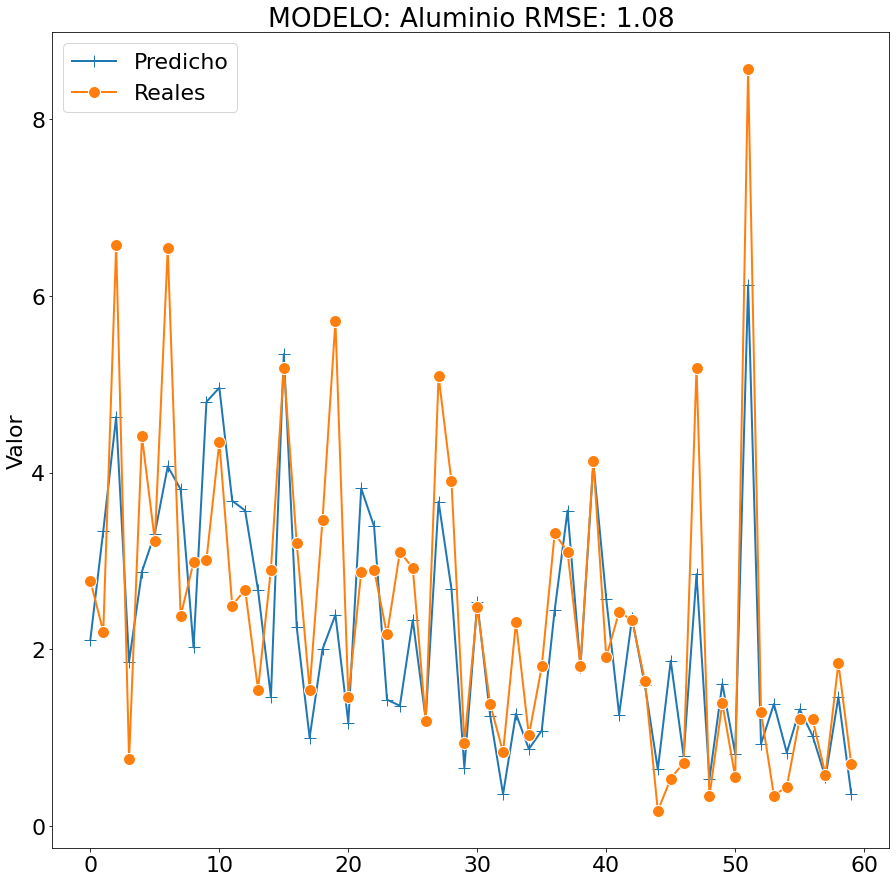

In [59]:
fig, ax = plt.subplots(figsize=(15,15))
x = np.arange(0,len(pred))
plt.title(f"MODELO: Aluminio RMSE: {round(rmse,2)}")
plt.rcParams.update({'font.size': 22})
ax.plot(x, pred, marker='+', label='Predicho',linewidth=2, markersize=12)
ax.plot(x, y, marker='o', markeredgecolor='w', label='Reales',linewidth=2, markersize=12)
ax.set_ylabel('Valor')
ax.legend(loc='upper left')
plt.show()

# CIC

In [13]:
df_cic = df[[ 'ph', 'n', 'mo', 'k', 'ca', 'mg','cic']]

In [14]:
cols = df_cic.columns.values
df_cic = df_cic.replace(",",".",regex=True)

In [15]:
df_cic[cols] = df_cic[cols].apply(pd.to_numeric, errors='coerce', axis=1)
df_cic = df_cic.dropna()

In [16]:
X = df_cic[['ph', 'mo', 'k', 'ca', 'mg']]
y = df_cic["cic"]

In [17]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import GridSearchCV


sc = StandardScaler()
train_cbe = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(train_cbe, y,
test_size=0.2,random_state=42)

model =  cb.CatBoostRegressor(iterations=3000,
                             learning_rate=0.01,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 1,
                             od_type='Iter',
                             metric_period = 10,
                             od_wait=100)
model.fit(X_train, y_train,
                 eval_set=(X_test, y_test),
                 use_best_model=True)

pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print("Testing performance")
print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

0:	learn: 7.7702167	test: 7.6768423	best: 7.6768423 (0)	total: 10.6ms	remaining: 31.7s
10:	learn: 7.4174371	test: 7.3256249	best: 7.3256249 (10)	total: 104ms	remaining: 28.2s
20:	learn: 7.1073294	test: 7.0154901	best: 7.0154901 (20)	total: 203ms	remaining: 28.8s
30:	learn: 6.8317910	test: 6.7458406	best: 6.7458406 (30)	total: 308ms	remaining: 29.5s
40:	learn: 6.5884285	test: 6.5067927	best: 6.5067927 (40)	total: 409ms	remaining: 29.5s
50:	learn: 6.3793540	test: 6.3044091	best: 6.3044091 (50)	total: 511ms	remaining: 29.5s
60:	learn: 6.1939780	test: 6.1251954	best: 6.1251954 (60)	total: 624ms	remaining: 30.1s
70:	learn: 6.0318873	test: 5.9670728	best: 5.9670728 (70)	total: 719ms	remaining: 29.7s
80:	learn: 5.8916753	test: 5.8335420	best: 5.8335420 (80)	total: 819ms	remaining: 29.5s
90:	learn: 5.7645444	test: 5.7134450	best: 5.7134450 (90)	total: 923ms	remaining: 29.5s
100:	learn: 5.6541154	test: 5.6118223	best: 5.6118223 (100)	total: 1.03s	remaining: 29.5s
110:	learn: 5.5545962	test: 5.5

In [ ]:
import pickle
pickle.dump(sc, open('sc_cic.pkl','wb'))
pickle.dump(model, open('model_cic.pkl','wb'))

In [299]:
test_df = pd.read_excel("test.xlsx",sheet_name="CIC")
test_df = test_df[['pH', 'M.O.', 'CIC', 'K', 'Ca', 'Mg']]
X = test_df[['pH', 'M.O.',  'K', 'Ca', 'Mg']]
y = test_df[["CIC"]]
test = sc.transform(X)
pred = model.predict(test)
rmse = (np.sqrt(mean_squared_error(y, pred)))
r2 = r2_score(y, pred)
print("Testing performance")
print("RMSE: {:.2f}".format(rmse))
print("R2: {:.2f}".format(r2))

Testing performance
RMSE: 5.57
R2: 0.72


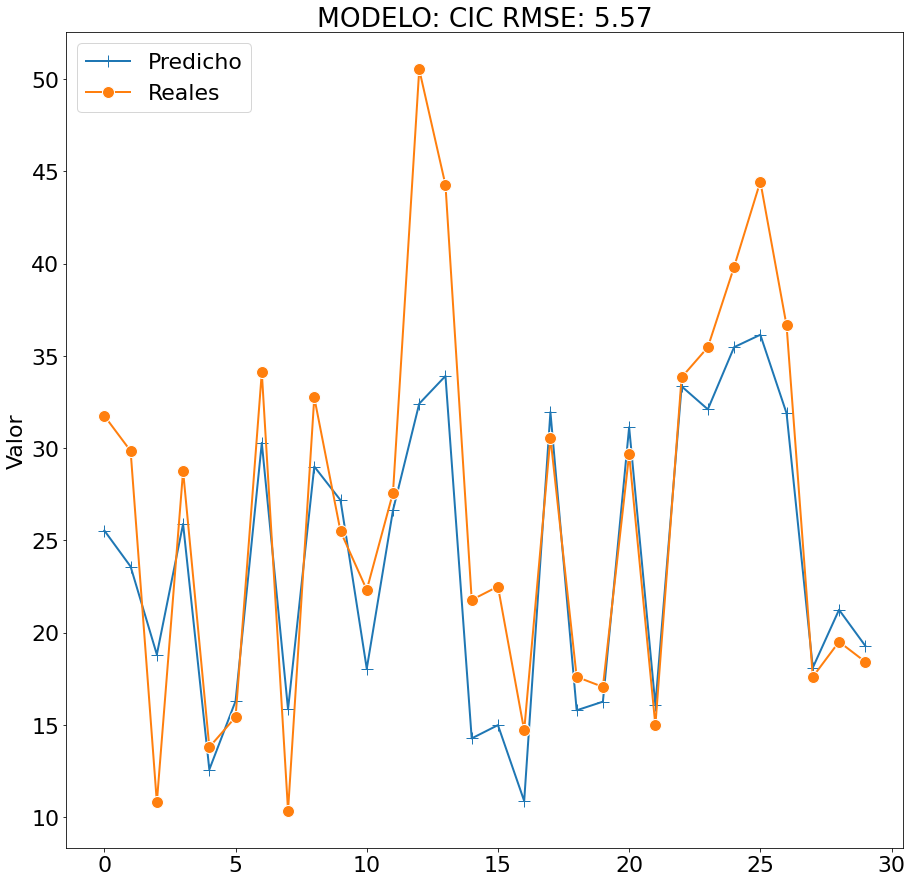

In [300]:
fig, ax = plt.subplots(figsize=(15,15))
x = np.arange(0,len(pred))
plt.title(f"MODELO: CIC RMSE: {round(rmse,2)}")
plt.rcParams.update({'font.size': 22})
ax.plot(x, pred, marker='+', label='Predicho',linewidth=2, markersize=12)
ax.plot(x, y, marker='o', markeredgecolor='w', label='Reales',linewidth=2, markersize=12)
ax.set_ylabel('Valor')
ax.legend(loc='upper left')
plt.show()